# Simple Pandemic Simulation
### by Stan Mohler, Jr.
November 2020

Here is my very simple "SIR" simulation of a COVID19-like pandemic, inspired by [this page](https://forum.bayesia.us/t/p8hymxb/webinar-series-reasoning-under-uncertainty-part-3-epidemic-modeling-with-temporal-bayesian-networks) and [this page](https://phys.org/news/2020-03-mathematical-epidemiology-pandemic.html).

My simulation follows these simple rules:

* There are 330 million people.  Initially, one is infected.  
* In one scenario, each infected person infects 1.25 other people, over 14 days.  (2.5 people in the other scenario.)  
* 1% of the infected die.  The rest become immune.  
* As the pool of susceptible people shrinks, the infection rate slows, in proportion.  

Here's a diagram:

![Simulation transition diagram](SIDR.PNG)

Do you think slowing the spread will save lives?  Or just delay the inevitable?  

**To skip ahead to the answer, scroll down to the four graphs.**

When a pandemic starts, the initial reproduction number (called R0) tells how many people each infected person infects.  (NPR explains it [here](https://www.npr.org/2020/06/11/875311157/will-nationwide-protests-drive-up-the-coronavirus-cases).)  Early on, COVID-19's R0 was estimated to be about 2.5.  (Since then, it's been [revised upward](https://www.forbes.com/sites/tarahaelle/2020/04/07/the-covid19-coronavirus-disease-may-be-twice-as-contagious-as-we-thought/#7665486729a6), but I'll assume 2.5.  It's just a simulation!)  

Over time, the actual "effective" reproduction number, called Rt, deviates from R0 and [varies over time](https://rt.live), generally downward.  Masks and social distancing reduce Rt.  Growing "herd immunity" does too.  When Rt is less than 1.0, the viral spread is diminshing.  

So here are the two scenarios:

| Scenario | R0 value | Description |
| :---     | :---     | :---        |
| 1        | 1.25     | "Slow the spread" |
| 2        | 2.5      | "Live normally, rush to herd immunity" |  

Like I said, this is a simple simulation.  But it's just complex enough to encompass essential epidemiological dynamics.  

### So...

First, import our Python software libraries.  

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Next, define our constants.  

In [4]:
NUM_DAYS_SIMULATED                 = 1000
NUM_DAYS_INFECTIOUS                = 14
DEATH_RATE                         = 0.01
TOTAL_POPULATION                   = 330e6
INITIAL_NUM_INFECTED               = 1

LOW_INITIAL_REPRODUCTION_NUMBER    = 1.25    # R0, the initial no. of people each contagious person infects
HIGH_INITIAL_REPRODUCTION_NUMBER   = 2.5     # R0 for less social distancing
MAX_DAYS_SOCIAL_DISTANCING         = 9999    # eventually, both scenarios go back to "normal living"

Initialize some empty lists to store the results.  

In [5]:
num_susceptible_arry_arry = []
num_infected_arry_arry    = []
num_immune_arry_arry      = []
num_dead_arry_arry        = []

herd_immunity_day = []
total_dead        = []

Loop over the two scenarios.  
For each, loop over all the days of the scenario.  

In [6]:
for s in range(2):  # LOOP OVER TWO SCENARIOS

    infection_dissipating = False
    infection_gone = False

    # set R0 for the current scenario
    
    initial_reproduction_number = LOW_INITIAL_REPRODUCTION_NUMBER
    if s == 1:
        initial_reproduction_number = HIGH_INITIAL_REPRODUCTION_NUMBER

    print(f'\n\nSCENARIO {s+1} OF 2: Initial reproduction no. = {initial_reproduction_number}')

    # set initial values of the 4 quantities to compute and plot
    
    num_susceptible = TOTAL_POPULATION - INITIAL_NUM_INFECTED
    num_infected    = INITIAL_NUM_INFECTED
    num_immune      = 0
    num_dead        = 0

    # initialize arrays to store the time history of the quantities for one scenario
    
    num_susceptible_arry     = [ num_susceptible ]
    num_infected_arry        = [ num_infected ]
    num_immune_arry          = [ num_immune ]
    num_dead_arry            = [ num_dead ]
    num_infected_today_arry  = [ num_infected ]
    num_recovered_today_arry = [ 0 ]

    # LOOP OVER THE DAYS BEING SIMULATED

    t_10_deaths = None

    for t in range(NUM_DAYS_SIMULATED):

        # when certain things happen, print a message
        
        if num_infected == 0 and not infection_gone:
            infection_gone = True
            
            if initial_reproduction_number < HIGH_INITIAL_REPRODUCTION_NUMBER:
                initial_reproduction_number = HIGH_INITIAL_REPRODUCTION_NUMBER 
                herd_immunity_day.append(t)
                total_dead.append(num_dead)
                percent_immune = 100 * num_immune / (TOTAL_POPULATION - num_dead)
                print(f'Day {t+1:4}: INFECTION GONE.  {num_dead:.0f} dead.  {percent_immune:.0f}% immune.  ENDING SOCIAL DISTANCING.')

            else:
                herd_immunity_day.append(t)
                total_dead.append(num_dead)
                percent_immune = 100 * num_immune / (TOTAL_POPULATION - num_dead)
                print(f'Day {t+1:4}: INFECTION GONE.  {num_dead:.0f} dead.  {percent_immune:.0f}% immune.')

        # after a long time, both scenarios go to the high initial reproduction number
        # to represent "return to normal" social behavior
        
        if t >= MAX_DAYS_SOCIAL_DISTANCING and initial_reproduction_number < HIGH_INITIAL_REPRODUCTION_NUMBER:
            print(f'Day {t+1:4}: HIT LIMIT ON DAYS TO SOCIAL DISTANCE.')
            initial_reproduction_number = HIGH_INITIAL_REPRODUCTION_NUMBER
        
        # sick people infect others in proportion to how many are susceptible
        
        effective_reproduction_number = initial_reproduction_number * num_susceptible / num_susceptible_arry[0]

        # check whether virus is dissipating
        
        if not infection_dissipating and effective_reproduction_number < 1.0:
            infection_dissipating = True
            percent_immune = 100 * num_immune / (TOTAL_POPULATION - num_dead)
            print(f'Day {t+1:4}: VIRUS IS DISSIPATING: Reproduction number < 1.  {percent_immune:.0f}% immune.')

        # each sick person infects their "victims" over several days
        
        num_infected_today = num_infected * effective_reproduction_number / NUM_DAYS_INFECTIOUS

        # set default values, which might change farther below
        
        num_recovered_today     = 0.0
        num_deaths_today        = 0.0
        num_lost_immunity_today = 0.0
        
        if t >= NUM_DAYS_INFECTIOUS:
            
            # then some infectious people lose their infectiousness today.  
            # How many?  The no. who became infectious NUM_DAYS_INFECTIOUS days ago.  
            
            num_losing_infectiousness = num_infected_today_arry[ t - NUM_DAYS_INFECTIOUS ]
            num_recovered_today = (1.0 - DEATH_RATE) * num_losing_infectiousness  # most people recover
            num_deaths_today = DEATH_RATE * num_losing_infectiousness             # but some die

        # HEART OF THE SIMULATION: UPDATE THE 4 QUANTITIES WE WILL PLOT
        
        num_susceptible = num_susceptible - num_infected_today
        num_infected    = num_infected + num_infected_today - num_recovered_today - num_deaths_today
        num_immune      = num_immune + num_recovered_today
        num_dead        = num_dead + num_deaths_today

        # enable infection to disappear
        
        if num_infected < 1.0:
            num_infected = 0

        # append the quantities updated above into the time histories
        
        num_susceptible_arry.append( num_susceptible )        
        num_infected_today_arry.append( num_infected_today )
        num_recovered_today_arry.append( num_recovered_today )
        num_infected_arry.append( num_infected )
        num_immune_arry.append( num_immune )
        num_dead_arry.append( num_dead )

        # PRINT SOME STUFF

        if t == 0 or t == 1 or t > NUM_DAYS_SIMULATED-4:
            print(f'Day {t+1:4}: S={num_susceptible:.2f}  I={num_infected:.2f}  R={num_immune:.2f}  D={num_dead:.2f}')
        
        if t_10_deaths == None and num_dead >= 10:
            t_10_deaths = t

        if t_10_deaths != None and (t - t_10_deaths) == 202:
            # US saw 200,000 deaths 200 days after seeing 10 deaths
            print(f'Day {t+1:4}: 202 days since 10 deaths: US had 200,000 deaths.  Sim has {num_dead:.0f}.')

        # sanity check: total people count should stay constant
        
        people_count = num_susceptible + num_infected + num_immune + num_dead   # should stay constant
        people_count_error = abs(people_count - TOTAL_POPULATION)
        if people_count_error >= 1:
            print(f'ERROR: People count started at {TOTAL_POPULATION} but is now {people_count}')
            exit()

    # store the latest scenario

    num_susceptible_arry_arry.append(num_susceptible_arry)
    num_infected_arry_arry.append(num_infected_arry)
    num_immune_arry_arry.append(num_immune_arry)
    num_dead_arry_arry.append(num_dead_arry)



SCENARIO 1 OF 2: Initial reproduction no. = 1.25
Day    1: S=329999998.91  I=1.09  R=0.00  D=0.00
Day    2: S=329999998.81  I=1.19  R=0.00  D=0.00
Day  364: 202 days since 10 deaths: US had 200,000 deaths.  Sim has 22358.
Day  453: VIRUS IS DISSIPATING: Reproduction number < 1.  14% immune.
Day  935: INFECTION GONE.  1525151 dead.  46% immune.  ENDING SOCIAL DISTANCING.
Day  998: S=177484855.51  I=0.00  R=150989993.05  D=1525151.44
Day  999: S=177484855.51  I=0.00  R=150989993.05  D=1525151.44
Day 1000: S=177484855.51  I=0.00  R=150989993.05  D=1525151.44


SCENARIO 2 OF 2: Initial reproduction no. = 2.5
Day    1: S=329999998.82  I=1.18  R=0.00  D=0.00
Day    2: S=329999998.61  I=1.39  R=0.00  D=0.00
Day  135: VIRUS IS DISSIPATING: Reproduction number < 1.  15% immune.
Day  262: 202 days since 10 deaths: US had 200,000 deaths.  Sim has 3041083.
Day  265: INFECTION GONE.  3041083 dead.  92% immune.
Day  998: S=25891738.66  I=0.00  R=301067178.73  D=3041082.61
Day  999: S=25891738.66  

Finally, plot the results.  

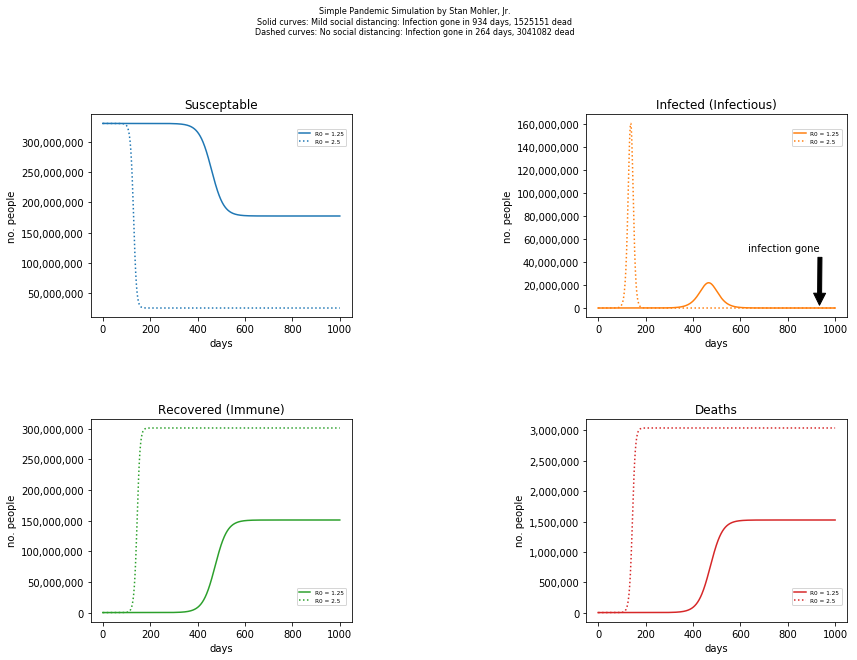

In [7]:
plt.rcParams['figure.figsize'] = 15, 10  # nice big plots
fig, axs = plt.subplots(2, 2)            # 4 plots

# note the day herd immunity was reached & the no. dead

herd_immunity_day_scenario0  = str(herd_immunity_day[0])
final_num_dead_scenario_0    = str(int(total_dead[0]))
herd_immunity_day_scenario_1 = str(herd_immunity_day[1])
final_num_dead_scenario_1    = str(int(total_dead[1]))

fig.suptitle('Simple Pandemic Simulation by Stan Mohler, Jr.\nSolid curves: Mild social distancing: Infection gone in '
              + herd_immunity_day_scenario0 + ' days, ' + final_num_dead_scenario_0 + ' dead\nDashed curves: No social distancing: Infection gone in '
              + herd_immunity_day_scenario_1 + ' days, ' + final_num_dead_scenario_1 + ' dead', fontsize=8)

axs[0, 0].set_title('Susceptable')
axs[0, 1].set_title('Infected (Infectious)')
axs[1, 0].set_title('Recovered (Immune)')
axs[1, 1].set_title('Deaths')

x = range(NUM_DAYS_SIMULATED + 1)

for s in range(2):

    linestyle = '-'
    label = 'R0 = ' + str(LOW_INITIAL_REPRODUCTION_NUMBER)

    if s==1:
        linestyle = ':'
        label = 'R0 = ' + str(HIGH_INITIAL_REPRODUCTION_NUMBER)

    axs[0,0].plot(x, num_susceptible_arry_arry[s], 'tab:blue', linestyle=linestyle, label=label)
    axs[0,1].plot(x, num_infected_arry_arry[s], 'tab:orange', linestyle=linestyle, label=label)
    axs[1,0].plot(x, num_immune_arry_arry[s], 'tab:green', linestyle=linestyle, label=label)
    axs[1,1].plot(x, num_dead_arry_arry[s], 'tab:red', linestyle=linestyle, label=label)

    axs[0,0].legend(bbox_to_anchor=(0.98, 0.93), loc='upper right', borderaxespad=0.02, fontsize='xx-small')
    axs[0,1].legend(bbox_to_anchor=(0.98, 0.93), loc='upper right', borderaxespad=0.02, fontsize='xx-small')
    axs[1,0].legend(bbox_to_anchor=(0.98, 0.08), loc='lower right', borderaxespad=0.02, fontsize='xx-small')
    axs[1,1].legend(bbox_to_anchor=(0.98, 0.08), loc='lower right', borderaxespad=0.02, fontsize='xx-small')

for ax in axs.flat:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set(xlabel='days', ylabel='no. people')

plt.subplots_adjust(left=0.2, bottom=None, right=None, top=0.83, wspace=0.9, hspace=0.5)

axs[0,1].annotate('infection gone', xy=(herd_immunity_day[0], 0), xytext=(herd_immunity_day[0]-300, 50e6),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

plt.show()

## Results
In the plots above: 
- Dotted curves mean normal life, hoping for rapid herd immunity.  
- Solid curves mean slowing the spread.  
- When everything truly levels off, the pandemic is over.  The virus is gone.  

In the upper right **<span style="color:orange"> orange plot </span>**, notice: 
- **Slowing the spread delays the peak of the infection, widens it, and drastically reduces its height.**  (All very helpful to hospitals and patients).
- Therefore a better simulation would dramatically increase the death rate for that high dotted peak in which **half the country** (!) is infected at the same time.  
- Slowing the spread can cause the virus **to appear almost non-existent for a long time**, but then **suddenly explode into visibility** (as happens by day 400).  
- This deceptive illusion of "nothing happening" is removed via a log plot, shown below, in which 10 is replaced by 1, 100 is replaced by 2, 1000 is replaced by 3, etc.  As you can see, the virus is actually spreading at a constant exponential rate, getting worse and worse, long before the **surprise "explosion"**.  (Maybe that's why CDC director Redfield warned in August that [fall 2020 could be "the worst"](https://www.npr.org/sections/coronavirus-live-updates/2020/08/13/902388083/cdc-director-warns-this-fall-could-be-the-worst-ever-for-public-health) for public health.)  

![Log of people infected](LogNumPeople.PNG)

In the first four plots above, the lower right **<span style="color:red"> red curves </span>** have the key findings:
- Allowing the virus to rapidly spread **ends the pandemic much sooner**. BUT it ends up **killing far more people**.  That's because the rate of new infections out-races the growing herd immunity.  Many more people die before a given level of herd immunity can do its job.  
- **Slowing the spread definitely delays herd immunity, by a long time.**  Years, even.  
- **BUT IT DRAMATICALLY REDUCES THE NUMBER OF DEATHS.**  In this case, it cuts deaths in half, saving about 1.5 million lives.  (Even more if you consider that hospitals wouldn't be overwhelmed.)

### Therefore, living life as normal would lead to disaster.  
### It would kill millions of people who are saved by slowing the spread.

Now consider a 3rd strategy:
- Let the virus spread at its natural rate (R0 = 2.5 here) until 100 people are infected.  
- At that point, impose a tight lockdown, possibly just in the vicinity of those 100 people, stopping further infection in its tracks (Rt = 0).  
- Stay locked down until all those 100 people become incapable of spreading the infection - about 14 days.  (In real life, we'd have to test widely, to discover all infections, including surprise pop-ups.)  
- Then, let R0 rise back to 2.5, i.e., resume normal life.

What would happen?

It seems obvious: It would end the pandemic in a matter of days, with only a few deaths.  

Is such a strategy realistic?  

**Yes.**  It was implemented **in real life** by the WHO's GPHIN, which nipped SARS in the bud **in 2003, preventing a global pandemic**.  Dr. Larry Brilliant explains it 16 minutes into [his 2006 TED talk](https://www.youtube.com/watch?v=MNhiHf84P9c).  He also explains how he helped eradicate the smallpox virus from nature in 1980, and possibly polio.  (There are actually two frozen samples of smallpox, in American and Russian labs.)